<a href="https://colab.research.google.com/github/Wayne122/CMPE257/blob/main/Alternus_Vera_Content_Statistics_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alternus Vera - Part 2

Part 1: https://colab.research.google.com/drive/1Dmarwm1fLZnmMBknDbLaDmieP3a3xidB?usp=sharing

Topic: Content Statistics

Author: Han-Wei Lin

## Prerequisite

In [1]:
!python3 -m spacy download en_core_web_lg
# Then restart runtime

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


##Import library and data

### Liar-plus dataset

https://drive.google.com/file/d/1sFMftHLILNfuS0kpTlsbUzWpSNs3WkeD/view?usp=sharing

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1sFMftHLILNfuS0kpTlsbUzWpSNs3WkeD"})
downloaded.GetContentFile('liar_plus_dataset.zip')

In [3]:
from zipfile import ZipFile

In [4]:
with ZipFile('liar_plus_dataset.zip', 'r') as myzip:
    train_data = myzip.open('train2.tsv')
    test_data = myzip.open('test2.tsv')
    valid_data = myzip.open('val2.tsv')

train_p_df = pd.read_csv(train_data, sep='\t', header=None).drop([0], axis=1).dropna(how='all')
test_p_df = pd.read_csv(test_data, sep='\t', header=None).drop([0], axis=1).dropna(how='all')
valid_p_df = pd.read_csv(valid_data, sep='\t', header=None).drop([0], axis=1).dropna(how='all')

In [5]:
train_p_df[2].unique()

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'], dtype=object)

### Data preparation

#### Download tools

In [6]:
import nltk
nltk.download('punkt') # word_tokenize
nltk.download('averaged_perceptron_tagger') # pos_tag
nltk.download('tagsets') # help.upenn_tagset() to list all possible tags
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### All possible pos tags

In [7]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

#### Clean statement

In [8]:
!pip install num2words
from num2words import num2words
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
from datetime import datetime
import pandas as pd
import numpy as np
import re
import math

In [9]:
def get_wordnet_pos(sentence):
    """Map POS tag to first character lemmatize() accepts"""
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    words = []
    tags = []

    for tag in nltk.pos_tag(sentence):
        words.append(tag[0])
        tags.append(tag_dict.get(tag[1][0].upper(), wordnet.NOUN))

    return zip(words, tags)

In [10]:
def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

In [11]:
def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

In [12]:
def convert_numbers(data):
    tokens = nltk.word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text

In [161]:
def statement_preprocess(origin_df):
    
    df_copy = origin_df.copy()
    
    # lower the statement
    df_copy['preprocessed_statement'] = df_copy[3].str.lower()
    
    # filter out stop words and URLs
    en_stop_words = set(stopwords.words('english'))
    df_copy['preprocessed_statement'] = df_copy['preprocessed_statement'].apply(lambda row: ' '.join([word for word in row.split() if (word not in en_stop_words)]))

    # convert numbers
    df_copy['preprocessed_statement'] = df_copy['preprocessed_statement'].apply(lambda row: convert_numbers(row))

    # remove punctuation
    df_copy['preprocessed_statement'] = df_copy['preprocessed_statement'].apply(lambda row: remove_punctuation(row))

    # remove apostrophe
    df_copy['preprocessed_statement'] = df_copy['preprocessed_statement'].apply(lambda row: remove_apostrophe(row))

    # tokenize the statement
    tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
    df_copy['tokenized_statement'] = df_copy['preprocessed_statement'].apply(lambda row: tokenizer.tokenize(row))

    # lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    df_copy['lemmatized_token'] = df_copy['tokenized_statement'].apply(lambda row: [lemmatizer.lemmatize(w, t) for w, t in get_wordnet_pos(row)])

    # stem
    
    return df_copy

In [162]:
processed_train_df = statement_preprocess(train_p_df)
processed_test_df = statement_preprocess(test_p_df)

In [163]:
processed_test_df[[3, 'preprocessed_statement', 'tokenized_statement', 'lemmatized_token']]

,3,preprocessed_statement,tokenized_statement,lemmatized_token
0,Building a wall on the U.S.-Mexico border will...,building wall u s mexico border take literall...,"[building, wall, mexico, border, take, literal...","[build, wall, mexico, border, take, literally,..."
1,Wisconsin is on pace to double the number of l...,wisconsin pace double number layoffs year,"[wisconsin, pace, double, number, layoffs, year]","[wisconsin, pace, double, number, layoff, year]"
2,Says John McCain has done nothing to help the ...,says john mccain done nothing help vets,"[says, john, mccain, done, nothing, help, vets]","[say, john, mccain, do, nothing, help, vet]"
3,Suzanne Bonamici supports a plan that will cut...,suzanne bonamici supports plan cut choice med...,"[suzanne, bonamici, supports, plan, cut, choic...","[suzanne, bonamici, support, plan, cut, choice..."
4,When asked by a reporter whether hes at the ce...,asked reporter whether hes center criminal sc...,"[asked, reporter, whether, hes, center, crimin...","[ask, reporter, whether, he, center, criminal,..."
...,...,...,...,...
1262,Says his budget provides the highest state fun...,says budget provides highest state funding le...,"[says, budget, provides, highest, state, fundi...","[say, budget, provide, high, state, funding, l..."
1263,Ive been here almost every day.,ive almost every day,"[ive, almost, every, day]","[ive, almost, every, day]"
1264,"In the early 1980s, Sen. Edward Kennedy secret...",early 1980s sen edward kennedy secretly offe...,"[early, sen, edward, kennedy, secretly, offere...","[early, sen, edward, kennedy, secretly, offer,..."
1265,Says an EPA permit languished under Strickland...,says epa permit languished strickland new epa...,"[says, epa, permit, languished, strickland, ne...","[say, epa, permit, languish, strickland, new, ..."


#### Training data

##### Transforming token to pos tag

In [164]:
train_postags = []
for i, c in enumerate(processed_train_df['lemmatized_token']):
    train_postags.append([t[1] for t in nltk.pos_tag(c)])
    if i < 5:
        print(train_postags[-1])

['VB', 'NNS', 'JJ', 'JJ', 'NN', 'NN', 'JJ', 'NN', 'NN', 'NN']
['NN', 'NN', 'VB', 'VB', 'JJ', 'NN', 'VB', 'JJ', 'VB', 'NN', 'NN', 'JJ', 'NN']
['JJ', 'NN', 'VBP', 'NN', 'NN', 'IN', 'NN', 'VB', 'NN', 'NN', 'VBP', 'NN', 'NN']
['NN', 'NN', 'NN', 'NN', 'JJ', 'NN', 'JJ', 'NN', 'NN', 'NN']
['JJ', 'NN', 'VBP', 'VB', 'NN']


##### Pos count

In [165]:
train_tag_counters = []

for tags in train_postags:
    tag_counter = {
        'JJ': 0,
        'JJR': 0,
        'JJS': 0,
        'NN': 0,
        'NNP': 0,
        'NNPS': 0,
        'NNS': 0,
        'RB': 0,
        'RBR': 0,
        'RBS': 0,
        'VB': 0,
        'VBD': 0,
        'VBG': 0,
        'VBN': 0,
        'VBP': 0,
        'VBZ': 0,
    }
    for tag in tags:
        if tag in tag_counter:
            tag_counter[tag] += 1
    train_tag_counters.append(tag_counter)

##### Combining

In [166]:
jjl = []
nnl = []
rbl = []
vbl = []

for tct in train_tag_counters:
    tct_values = list(tct.values())
    jjl.append(tct_values[0]+tct_values[1]+tct_values[2])
    nnl.append(tct_values[3]+tct_values[4]+tct_values[5]+tct_values[6])
    rbl.append(tct_values[7]+tct_values[8]+tct_values[9])
    vbl.append(tct_values[10]+tct_values[11]+tct_values[12]+tct_values[13]+
               tct_values[14]+tct_values[15])

In [167]:
train_set = train_p_df.loc[:, [2]].replace('pants-fire', 0).replace('false', 1).replace('barely-true', 2).replace('half-true', 3).replace('mostly-true', 4).replace('true', 5)

In [168]:
train_set['JJ'] = jjl
train_set['NN'] = nnl
train_set['RB'] = rbl
train_set['VB'] = vbl

train_set

,2,JJ,NN,RB,VB
0,1,3,6,0,1
1,3,3,6,0,4
2,4,1,8,0,3
3,1,2,8,0,0
4,3,1,2,0,2
...,...,...,...,...,...
10237,4,1,7,0,0
10238,4,3,3,0,1
10239,3,4,10,0,2
10240,1,0,5,0,1


#### Testing data

##### Transforming token to pos tag

In [169]:
test_postags = []
for i, c in enumerate(processed_test_df['lemmatized_token']):
    test_postags.append([t[1] for t in nltk.pos_tag(c)])
    if i < 5:
        print(test_postags[-1])

['VB', 'NN', 'NN', 'NN', 'VB', 'RB', 'NN']
['NN', 'NN', 'JJ', 'NN', 'IN', 'NN']
['VB', 'NN', 'NN', 'VBP', 'NN', 'NN', 'NN']
['NN', 'NN', 'NN', 'NN', 'VBN', 'NN', 'NN', 'NN', 'JJ']
['VB', 'NN', 'IN', 'PRP', 'VBD', 'JJ', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'VBZ', 'NNS']


##### Pos count

In [170]:
test_tag_counters = []

for tags in test_postags:
    tag_counter = {
        'JJ': 0,
        'JJR': 0,
        'JJS': 0,
        'NN': 0,
        'NNP': 0,
        'NNPS': 0,
        'NNS': 0,
        'RB': 0,
        'RBR': 0,
        'RBS': 0,
        'VB': 0,
        'VBD': 0,
        'VBG': 0,
        'VBN': 0,
        'VBP': 0,
        'VBZ': 0,
    }
    for tag in tags:
        if tag in tag_counter:
            tag_counter[tag] += 1
    test_tag_counters.append(tag_counter)

##### Combining

In [171]:
jjl = []
nnl = []
rbl = []
vbl = []

for tct in test_tag_counters:
    tct_values = list(tct.values())
    jjl.append(tct_values[0]+tct_values[1]+tct_values[2])
    nnl.append(tct_values[3]+tct_values[4]+tct_values[5]+tct_values[6])
    rbl.append(tct_values[7]+tct_values[8]+tct_values[9])
    vbl.append(tct_values[10]+tct_values[11]+tct_values[12]+tct_values[13]+
               tct_values[14]+tct_values[15])

In [172]:
test_set = test_p_df.loc[:, [2]].replace('pants-fire', 0).replace('false', 1).replace('barely-true', 2).replace('half-true', 3).replace('mostly-true', 4).replace('true', 5)

In [173]:
test_set['JJ'] = jjl
test_set['NN'] = nnl
test_set['RB'] = rbl
test_set['VB'] = vbl

test_set

,2,JJ,NN,RB,VB
0,5,0,4,1,2
1,1,1,4,0,0
2,1,0,5,0,2
3,3,1,7,0,1
4,0,1,9,0,3
...,...,...,...,...,...
1262,3,1,6,1,1
1263,2,1,1,1,0
1264,2,3,7,3,2
1265,2,3,4,0,4


### Applying Sentiment Analysis

In [174]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Add to training data

In [175]:
sid = SentimentIntensityAnalyzer()

SA_C = []
SA_P = []
SA_NU = []
SA_NG = []

for sentence in train_p_df[3]:
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        if k == 'compound':
            SA_C.append(ss[k])
        elif k == 'pos':
            SA_P.append(ss[k])
        elif k == 'neu':
            SA_NU.append(ss[k])
        elif k == 'neg':
            SA_NG.append(ss[k])

In [176]:
train_set['SA_C'] = SA_C
train_set['SA_P'] = SA_P
train_set['SA_NU'] = SA_NU
train_set['SA_NG'] = SA_NG

train_set

,2,JJ,NN,RB,VB,SA_C,SA_P,SA_NU,SA_NG
0,1,3,6,0,1,0.2500,0.192,0.692,0.115
1,3,3,6,0,4,0.3612,0.098,0.902,0.000
2,4,1,8,0,3,0.3182,0.206,0.687,0.107
3,1,2,8,0,0,0.7579,0.394,0.606,0.000
4,3,1,2,0,2,0.0000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...
10237,4,1,7,0,0,-0.7506,0.062,0.619,0.319
10238,4,3,3,0,1,0.4019,0.172,0.828,0.000
10239,3,4,10,0,2,0.5859,0.161,0.839,0.000
10240,1,0,5,0,1,0.0000,0.000,1.000,0.000


#### Add to testing data

In [177]:
sid = SentimentIntensityAnalyzer()

SA_C = []
SA_P = []
SA_NU = []
SA_NG = []

for sentence in test_p_df[3]:
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        if k == 'compound':
            SA_C.append(ss[k])
        elif k == 'pos':
            SA_P.append(ss[k])
        elif k == 'neu':
            SA_NU.append(ss[k])
        elif k == 'neg':
            SA_NG.append(ss[k])

In [178]:
test_set['SA_C'] = SA_C
test_set['SA_P'] = SA_P
test_set['SA_NU'] = SA_NU
test_set['SA_NG'] = SA_NG

test_set

,2,JJ,NN,RB,VB,SA_C,SA_P,SA_NU,SA_NG
0,5,0,4,1,2,0.0000,0.000,1.000,0.000
1,1,1,4,0,0,0.0772,0.106,0.894,0.000
2,1,0,5,0,2,-0.3089,0.000,0.799,0.201
3,3,1,7,0,1,0.3400,0.288,0.577,0.135
4,0,1,9,0,3,-0.5994,0.099,0.659,0.242
...,...,...,...,...,...,...,...,...,...
1262,3,1,6,1,1,0.0000,0.000,1.000,0.000
1263,2,1,1,1,0,0.0000,0.000,1.000,0.000
1264,2,3,7,3,2,0.4019,0.119,0.881,0.000
1265,2,3,4,0,4,0.0000,0.000,1.000,0.000


### Applying NER - spaCy

In [179]:
# Restart runtime before running this cell
import spacy
sp_lg = spacy.load('en_core_web_lg') 

In [180]:
def spacy_large_ner(document):
    return [ent.label_ for ent in sp_lg(document).ents]

In [181]:
def ner_counter(ner_list):
    pers = 0
    norp = 0
    fac = 0
    org = 0
    gpe = 0
    loc = 0
    prod = 0
    eve = 0
    woa = 0
    law = 0
    lang = 0
    dat = 0
    tim = 0
    per = 0
    mon = 0
    quan = 0
    ordi = 0
    cardi = 0

    for n in ner_list:
        if n == 'PERSON':
            pers += 1
        elif n == 'NORP':
            norp += 1
        elif n == 'FAC':
            fac += 1
        elif n == 'ORG':
            org += 1
        elif n == 'GPE':
            gpe += 1
        elif n == 'LOC':
            loc += 1
        elif n == 'PRODUCT':
            prod += 1
        elif n == 'EVENT':
            eve += 1
        elif n == 'WORK_OF_ART':
            woa += 1
        elif n == 'LAW':
            law += 1
        elif n == 'LANGUAGE':
            lang += 1
        elif n == 'DATE':
            dat += 1
        elif n == 'TIME':
            tim += 1
        elif n == 'PERCENT':
            per += 1
        elif n == 'MONEY':
            mon += 1
        elif n == 'QUANTITY':
            quan += 1
        elif n == 'ORDINAL':
            ordi += 1
        elif n == 'CARDINAL':
            cardi += 1
    return [pers, norp, fac, org, gpe, loc, prod, eve, woa, law, lang, dat, tim,\
            per, mon, quan, ordi, cardi]

#### Add to training data

In [182]:
NER_pers = []
NER_norp = []
NER_fac = []
NER_org = []
NER_gpe = []
NER_loc = []
NER_prod = []
NER_eve = []
NER_woa = []
NER_law = []
NER_lang = []
NER_dat = []
NER_tim = []
NER_per = []
NER_mon = []
NER_quan = []
NER_ordi = []
NER_cardi = []

for statement in train_p_df[3]:
    ner_count = ner_counter(spacy_large_ner(statement))

    NER_pers.append(ner_count[0])
    NER_norp.append(ner_count[1])
    NER_fac.append(ner_count[2])
    NER_org.append(ner_count[3])
    NER_gpe.append(ner_count[4])
    NER_loc.append(ner_count[5])
    NER_prod.append(ner_count[6])
    NER_eve.append(ner_count[7])
    NER_woa.append(ner_count[8])
    NER_law.append(ner_count[9])
    NER_lang.append(ner_count[10])
    NER_dat.append(ner_count[11])
    NER_tim.append(ner_count[12])
    NER_per.append(ner_count[13])
    NER_mon.append(ner_count[14])
    NER_quan.append(ner_count[15])
    NER_ordi.append(ner_count[16])
    NER_cardi.append(ner_count[17])

In [183]:
train_set['NER_pers'] = NER_pers
train_set['NER_norp'] = NER_norp
train_set['NER_fac'] = NER_fac
train_set['NER_org'] = NER_org
train_set['NER_gpe'] = NER_gpe
train_set['NER_loc'] = NER_loc
train_set['NER_prod'] = NER_prod
train_set['NER_eve'] = NER_eve
train_set['NER_woa'] = NER_woa
train_set['NER_law'] = NER_law
train_set['NER_lang'] = NER_lang
train_set['NER_dat'] = NER_dat
train_set['NER_tim'] = NER_tim
train_set['NER_per'] = NER_per
train_set['NER_mon'] = NER_mon
train_set['NER_quan'] = NER_quan
train_set['NER_ordi'] = NER_ordi
train_set['NER_cardi'] = NER_cardi

train_set

,2,JJ,NN,RB,VB,SA_C,SA_P,SA_NU,SA_NG,NER_pers,NER_norp,NER_fac,NER_org,NER_gpe,NER_loc,NER_prod,NER_eve,NER_woa,NER_law,NER_lang,NER_dat,NER_tim,NER_per,NER_mon,NER_quan,NER_ordi,NER_cardi
0,1,3,6,0,1,0.2500,0.192,0.692,0.115,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,3,3,6,0,4,0.3612,0.098,0.902,0.000,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,1,8,0,3,0.3182,0.206,0.687,0.107,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,2,8,0,0,0.7579,0.394,0.606,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,1,2,0,2,0.0000,0.000,1.000,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10237,4,1,7,0,0,-0.7506,0.062,0.619,0.319,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10238,4,3,3,0,1,0.4019,0.172,0.828,0.000,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10239,3,4,10,0,2,0.5859,0.161,0.839,0.000,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0
10240,1,0,5,0,1,0.0000,0.000,1.000,0.000,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Add to testing data

In [184]:
NER_pers = []
NER_norp = []
NER_fac = []
NER_org = []
NER_gpe = []
NER_loc = []
NER_prod = []
NER_eve = []
NER_woa = []
NER_law = []
NER_lang = []
NER_dat = []
NER_tim = []
NER_per = []
NER_mon = []
NER_quan = []
NER_ordi = []
NER_cardi = []

for statement in test_p_df[3]:
    ner_count = ner_counter(spacy_large_ner(statement))

    NER_pers.append(ner_count[0])
    NER_norp.append(ner_count[1])
    NER_fac.append(ner_count[2])
    NER_org.append(ner_count[3])
    NER_gpe.append(ner_count[4])
    NER_loc.append(ner_count[5])
    NER_prod.append(ner_count[6])
    NER_eve.append(ner_count[7])
    NER_woa.append(ner_count[8])
    NER_law.append(ner_count[9])
    NER_lang.append(ner_count[10])
    NER_dat.append(ner_count[11])
    NER_tim.append(ner_count[12])
    NER_per.append(ner_count[13])
    NER_mon.append(ner_count[14])
    NER_quan.append(ner_count[15])
    NER_ordi.append(ner_count[16])
    NER_cardi.append(ner_count[17])

In [185]:
test_set['NER_pers'] = NER_pers
test_set['NER_norp'] = NER_norp
test_set['NER_fac'] = NER_fac
test_set['NER_org'] = NER_org
test_set['NER_gpe'] = NER_gpe
test_set['NER_loc'] = NER_loc
test_set['NER_prod'] = NER_prod
test_set['NER_eve'] = NER_eve
test_set['NER_woa'] = NER_woa
test_set['NER_law'] = NER_law
test_set['NER_lang'] = NER_lang
test_set['NER_dat'] = NER_dat
test_set['NER_tim'] = NER_tim
test_set['NER_per'] = NER_per
test_set['NER_mon'] = NER_mon
test_set['NER_quan'] = NER_quan
test_set['NER_ordi'] = NER_ordi
test_set['NER_cardi'] = NER_cardi

test_set

,2,JJ,NN,RB,VB,SA_C,SA_P,SA_NU,SA_NG,NER_pers,NER_norp,NER_fac,NER_org,NER_gpe,NER_loc,NER_prod,NER_eve,NER_woa,NER_law,NER_lang,NER_dat,NER_tim,NER_per,NER_mon,NER_quan,NER_ordi,NER_cardi
0,5,0,4,1,2,0.0000,0.000,1.000,0.000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,1,4,0,0,0.0772,0.106,0.894,0.000,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,0,5,0,2,-0.3089,0.000,0.799,0.201,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,1,7,0,1,0.3400,0.288,0.577,0.135,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,9,0,3,-0.5994,0.099,0.659,0.242,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,3,1,6,1,1,0.0000,0.000,1.000,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1263,2,1,1,1,0,0.0000,0.000,1.000,0.000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1264,2,3,7,3,2,0.4019,0.119,0.881,0.000,2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1265,2,3,4,0,4,0.0000,0.000,1.000,0.000,1,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0


#### Train models

In [186]:
X_train = train_set.drop(2, axis=1)
y_train = train_set[2]

In [187]:
X_test = test_set.drop(2, axis=1)
y_test = test_set[2]

In [188]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from time import time

In [189]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", #"Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

In [190]:
classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025, probability=True, random_state=0),
    SVC(gamma=2, C=1, probability=True, random_state=0),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5, random_state=0),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0),
    AdaBoostClassifier(random_state=0),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

##### Muller loop

In [191]:
max_score = 0.0
max_class = ''
for name, clf in zip(names, classifiers):
    start_time = time()
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time() - start_time))
    
    if score > max_score:
        clf_best_percData = clf
        max_score = score
        max_class = name

print(80*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))

Classifier = Nearest Neighbors, Score (test, accuracy) = 19.65, Training time = 0.24 seconds
Classifier = Linear SVM, Score (test, accuracy) = 24.94, Training time = 41.80 seconds
Classifier = RBF SVM, Score (test, accuracy) = 21.70, Training time = 84.69 seconds
Classifier = Decision Tree, Score (test, accuracy) = 24.70, Training time = 0.03 seconds
Classifier = Random Forest, Score (test, accuracy) = 21.55, Training time = 0.04 seconds
Classifier = Neural Net, Score (test, accuracy) = 24.47, Training time = 7.12 seconds
Classifier = AdaBoost, Score (test, accuracy) = 24.39, Training time = 0.65 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 9.63, Training time = 0.01 seconds
Classifier = QDA, Score (test, accuracy) = 7.18, Training time = 0.03 seconds
--------------------------------------------------------------------------------
Best --> Classifier = Linear SVM, Score (test, accuracy) = 24.94


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


##### Feature importance

In [192]:
pd.Series(classifiers[4].feature_importances_,X_train.columns).sort_values(ascending=False)

NER_pers     0.084559
SA_P         0.079740
SA_NU        0.072757
NER_cardi    0.071195
NER_dat      0.069180
RB           0.066271
NN           0.065182
SA_C         0.058966
VB           0.056922
JJ           0.044163
NER_per      0.042483
NER_woa      0.035760
NER_gpe      0.034913
NER_org      0.034846
SA_NG        0.033885
NER_ordi     0.026487
NER_quan     0.020434
NER_eve      0.016372
NER_fac      0.014654
NER_norp     0.013919
NER_mon      0.012646
NER_tim      0.012151
NER_prod     0.011818
NER_law      0.011344
NER_loc      0.007378
NER_lang     0.001976
dtype: float64

### Applying Topic Modeling

#### Find the best k for the topic number

In [38]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [70]:
statements_dictionary = Dictionary(processed_train_df.tokenized_statement)
statements_corpus = [statements_dictionary.doc2bow(tweet) for tweet in processed_train_df.tokenized_statement]

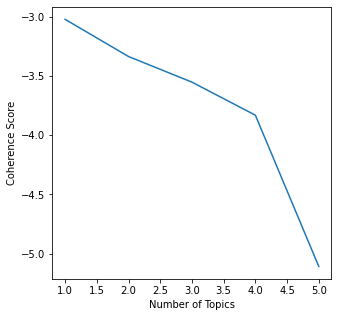

In [69]:
# compute coherence
statements_coherence = []
for nb_topics in range(1,6):
    lda = LdaModel(statements_corpus, num_topics = nb_topics, id2word = statements_dictionary, passes=10, random_state=0)
    cohm = CoherenceModel(model=lda, corpus=statements_corpus, dictionary=statements_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    statements_coherence.append(coh)

# visualize coherence
plt.figure(figsize=(5,5))
plt.plot(range(1,6),statements_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

#### Found k == 3, train the model and show the top words in each topic

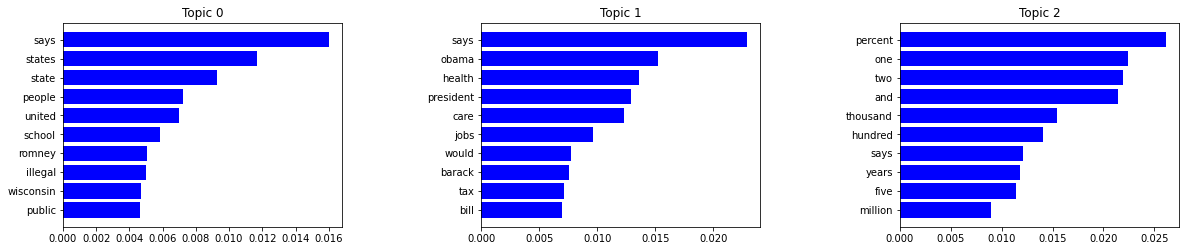

In [41]:
tpc_n = 3
statements_lda = LdaModel(statements_corpus, num_topics = tpc_n, id2word = statements_dictionary, passes=10, random_state=0)

def plot_top_words(lda=statements_lda, nb_topics=tpc_n, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(tpc_n))+1,round(math.sqrt(tpc_n))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))
        
  
plot_top_words()

#### Applying FastText vertorization to top 5 words from each topic

In [42]:
from gensim.models import FastText

In [63]:
sentences = processed_train_df.lemmatized_token
model = FastText(sentences, min_count=1, size=3)

In [64]:
ftvs = []
for t in range(tpc_n):
    for i, w in enumerate(statements_lda.show_topic(t, topn=5)):
        if i == 0:
            ftv = model.wv[w[0]]
        else:
            ftv = np.concatenate((ftv, model.wv[w[0]]))
    ftvs.append(ftv)

In [65]:
ftvs = np.asarray(ftvs)

#### Add to training data

In [71]:
vector_list = []

tpv = statements_lda[statements_corpus]
for statement in tpv:
    t0p = 0
    t1p = 0
    t2p = 0
    for topic in statement:
        if topic[0] == 0:
            t0p = topic[1]
        if topic[0] == 1:
            t1p = topic[1]
        if topic[0] == 2:
            t2p = topic[1]
    mp = max(t0p, t1p, t2p)
    if t0p == mp:
        vector_list.append(ftvs[0])
    elif t1p == mp:
        vector_list.append(ftvs[1])
    elif t2p == mp:
        vector_list.append(ftvs[2])

In [72]:
train_set_t = train_set.copy() # Train Set with topic modeling information

In [73]:
train_set_t = pd.DataFrame(pd.np.column_stack([train_set_t, vector_list]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.


In [74]:
train_set_t

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,1.0,3.0,6.0,0.0,1.0,0.2500,0.192,0.692,0.115,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-2.838719,-0.103151,-1.861601,-3.760358,-0.245770,-4.751685,-3.286920,0.064280,-5.758605,-4.628900,0.283031,-1.616857,-4.214194,0.318410,-7.279961
1,3.0,3.0,6.0,0.0,4.0,0.3612,0.098,0.902,0.000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.838719,-0.103151,-1.861601,-3.760358,-0.245770,-4.751685,-3.286920,0.064280,-5.758605,-4.628900,0.283031,-1.616857,-4.214194,0.318410,-7.279961
2,4.0,1.0,8.0,0.0,3.0,0.3182,0.206,0.687,0.107,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.838719,-0.103151,-1.861601,-3.760358,-0.245770,-4.751685,-3.286920,0.064280,-5.758605,-4.628900,0.283031,-1.616857,-4.214194,0.318410,-7.279961
3,1.0,2.0,8.0,0.0,0.0,0.7579,0.394,0.606,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.838719,-0.103151,-1.861601,-3.760358,-0.245770,-4.751685,-3.286920,0.064280,-5.758605,-4.628900,0.283031,-1.616857,-4.214194,0.318410,-7.279961
4,3.0,1.0,2.0,0.0,2.0,0.0000,0.000,1.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.838719,-0.103151,-1.861601,-3.760358,-0.245770,-4.751685,-3.286920,0.064280,-5.758605,-4.628900,0.283031,-1.616857,-4.214194,0.318410,-7.279961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,4.0,1.0,7.0,0.0,0.0,-0.7506,0.062,0.619,0.319,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.838719,-0.103151,-1.861601,-2.657618,1.878898,-0.731376,-4.438571,3.199134,-1.162182,-3.609388,2.741146,-1.227087,-3.967890,2.039073,-0.460617
10236,4.0,3.0,3.0,0.0,1.0,0.4019,0.172,0.828,0.000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.259495,6.322192,0.070969,-4.471518,8.249652,-1.186120,-2.246224,9.511885,-0.786517,-5.043071,13.186522,-1.965288,-3.511334,7.682581,-2.037349
10237,3.0,4.0,10.0,0.0,2.0,0.5859,0.161,0.839,0.000,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.259495,6.322192,0.070969,-4.471518,8.249652,-1.186120,-2.246224,9.511885,-0.786517,-5.043071,13.186522,-1.965288,-3.511334,7.682581,-2.037349
10238,1.0,0.0,5.0,0.0,1.0,0.0000,0.000,1.000,0.000,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.259495,6.322192,0.070969,-4.471518,8.249652,-1.186120,-2.246224,9.511885,-0.786517,-5.043071,13.186522,-1.965288,-3.511334,7.682581,-2.037349


#### Add to testing data

In [75]:
statements_dictionary = Dictionary(processed_test_df.tokenized_statement)
statements_corpus = [statements_dictionary.doc2bow(tweet) for tweet in processed_test_df.tokenized_statement]

In [76]:
vector_list = []

tpv = statements_lda[statements_corpus]
for statement in tpv:
    t0p = 0
    t1p = 0
    t2p = 0
    for topic in statement:
        if topic[0] == 0:
            t0p = topic[1]
        if topic[0] == 1:
            t1p = topic[1]
        if topic[0] == 2:
            t2p = topic[1]
    mp = max(t0p, t1p, t2p)
    if t0p == mp:
        vector_list.append(ftvs[0])
    elif t1p == mp:
        vector_list.append(ftvs[1])
    elif t2p == mp:
        vector_list.append(ftvs[2])

In [77]:
test_set_t = test_set.copy() # Test Set with topic modeling information

In [78]:
test_set_t = pd.DataFrame(pd.np.column_stack([test_set_t, vector_list]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.


In [79]:
test_set_t

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,5.0,0.0,4.0,1.0,2.0,0.0000,0.000,1.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.838719,-0.103151,-1.861601,-3.760358,-0.245770,-4.751685,-3.286920,0.064280,-5.758605,-4.628900,0.283031,-1.616857,-4.214194,0.318410,-7.279961
1,1.0,1.0,4.0,0.0,0.0,0.0772,0.106,0.894,0.000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.259495,6.322192,0.070969,-4.471518,8.249652,-1.186120,-2.246224,9.511885,-0.786517,-5.043071,13.186522,-1.965288,-3.511334,7.682581,-2.037349
2,1.0,0.0,5.0,0.0,2.0,-0.3089,0.000,0.799,0.201,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.838719,-0.103151,-1.861601,-3.760358,-0.245770,-4.751685,-3.286920,0.064280,-5.758605,-4.628900,0.283031,-1.616857,-4.214194,0.318410,-7.279961
3,3.0,1.0,7.0,0.0,1.0,0.3400,0.288,0.577,0.135,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.838719,-0.103151,-1.861601,-3.760358,-0.245770,-4.751685,-3.286920,0.064280,-5.758605,-4.628900,0.283031,-1.616857,-4.214194,0.318410,-7.279961
4,0.0,1.0,9.0,0.0,3.0,-0.5994,0.099,0.659,0.242,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.838719,-0.103151,-1.861601,-3.760358,-0.245770,-4.751685,-3.286920,0.064280,-5.758605,-4.628900,0.283031,-1.616857,-4.214194,0.318410,-7.279961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,3.0,1.0,6.0,1.0,1.0,0.0000,0.000,1.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.259495,6.322192,0.070969,-4.471518,8.249652,-1.186120,-2.246224,9.511885,-0.786517,-5.043071,13.186522,-1.965288,-3.511334,7.682581,-2.037349
1263,2.0,1.0,1.0,1.0,0.0,0.0000,0.000,1.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.838719,-0.103151,-1.861601,-3.760358,-0.245770,-4.751685,-3.286920,0.064280,-5.758605,-4.628900,0.283031,-1.616857,-4.214194,0.318410,-7.279961
1264,2.0,3.0,7.0,3.0,2.0,0.4019,0.119,0.881,0.000,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.838719,-0.103151,-1.861601,-3.760358,-0.245770,-4.751685,-3.286920,0.064280,-5.758605,-4.628900,0.283031,-1.616857,-4.214194,0.318410,-7.279961
1265,2.0,3.0,4.0,0.0,4.0,0.0000,0.000,1.000,0.000,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.838719,-0.103151,-1.861601,-2.657618,1.878898,-0.731376,-4.438571,3.199134,-1.162182,-3.609388,2.741146,-1.227087,-3.967890,2.039073,-0.460617


#### Train models

In [80]:
X_train = train_set_t.drop(0, axis=1)
y_train = train_set_t[0]

In [81]:
X_test = test_set_t.drop(0, axis=1)
y_test = test_set_t[0]

##### Different Classifiers

In [59]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from time import time

In [60]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", #"Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

In [82]:
classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025, probability=True, random_state=0),
    SVC(gamma=2, C=1, probability=True, random_state=0),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5, random_state=0),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0),
    AdaBoostClassifier(random_state=0),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

##### Muller loop

In [83]:
max_score = 0.0
max_class = ''
for name, clf in zip(names, classifiers):
    start_time = time()
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time() - start_time))
    
    if score > max_score:
        clf_best_percData = clf
        max_score = score
        max_class = name

print(80*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))

Classifier = Nearest Neighbors, Score (test, accuracy) = 19.65, Training time = 0.27 seconds
Classifier = Linear SVM, Score (test, accuracy) = 21.31, Training time = 59.07 seconds
Classifier = RBF SVM, Score (test, accuracy) = 21.63, Training time = 112.57 seconds
Classifier = Decision Tree, Score (test, accuracy) = 21.70, Training time = 0.04 seconds
Classifier = Random Forest, Score (test, accuracy) = 21.23, Training time = 0.04 seconds
Classifier = Neural Net, Score (test, accuracy) = 23.36, Training time = 10.88 seconds
Classifier = AdaBoost, Score (test, accuracy) = 23.99, Training time = 0.80 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 10.34, Training time = 0.01 seconds
Classifier = QDA, Score (test, accuracy) = 7.42, Training time = 0.04 seconds
--------------------------------------------------------------------------------
Best --> Classifier = AdaBoost, Score (test, accuracy) = 23.99


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


##### Feature importance

In [84]:
pd.Series(classifiers[4].feature_importances_,X_train.columns).sort_values(ascending=False)

2     0.058767
32    0.057130
38    0.052886
35    0.050582
12    0.046544
1     0.046392
33    0.042858
26    0.042471
5     0.041145
7     0.040719
40    0.039388
9     0.038533
8     0.033813
6     0.033476
4     0.033123
20    0.031494
31    0.030039
23    0.024527
29    0.023981
13    0.021283
10    0.020503
25    0.019057
3     0.017969
41    0.015873
17    0.015456
11    0.013843
18    0.013137
15    0.012012
30    0.010700
22    0.009672
16    0.008798
14    0.007907
37    0.007754
21    0.007430
24    0.007085
39    0.006052
27    0.005304
28    0.005263
36    0.004898
19    0.002069
34    0.000069
dtype: float64

### Adding newly scraped data

ID: 1w3lAOZn5rMvuaEkMcs_9g4FKVmop_Udd

https://drive.google.com/file/d/1w3lAOZn5rMvuaEkMcs_9g4FKVmop_Udd/view?usp=sharing

In [115]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1w3lAOZn5rMvuaEkMcs_9g4FKVmop_Udd"})
downloaded.GetContentFile('NEWS.csv')

In [116]:
news_df = pd.read_csv('NEWS.csv', index_col=0)

In [149]:
news_df = news_df[news_df['Label'] != 'full-flop']

In [150]:
news_df.head()

,Statement,Link,Date,Source,Label
0,"Says “132,000 ballots in Fulton County, Ga., h...",https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Viral image,false
1,Says there are “indications of grossly imprope...,https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Dan Bishop,false
2,A “system glitch” in Wisconsin that “swapped v...,https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Eric Trump,false
3,"Overnight, election workers “found” 140,000 ma...",https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Facebook posts,false
4,Says CNN video shows “HAMMER / Scorecard Voter...,https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Pamela Geller,pants-fire


In [151]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1492 entries, 0 to 1499
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Statement  1492 non-null   object
 1   Link       1492 non-null   object
 2   Date       1492 non-null   object
 3   Source     1492 non-null   object
 4   Label      1492 non-null   object
dtypes: object(5)
memory usage: 69.9+ KB


#### Data preprocess

In [127]:
def statement_preprocess(origin_df):
    
    df_copy = origin_df.copy()
    
    # lower the statement
    df_copy['preprocessed_statement'] = df_copy['Statement'].str.lower()
    
    # filter out stop words and URLs
    en_stop_words = set(stopwords.words('english'))
    df_copy['preprocessed_statement'] = df_copy['preprocessed_statement'].apply(lambda row: ' '.join([word for word in row.split() if (word not in en_stop_words)]))

    # convert numbers
    df_copy['preprocessed_statement'] = df_copy['preprocessed_statement'].apply(lambda row: convert_numbers(row))

    # remove punctuation
    df_copy['preprocessed_statement'] = df_copy['preprocessed_statement'].apply(lambda row: remove_punctuation(row))

    # remove apostrophe
    df_copy['preprocessed_statement'] = df_copy['preprocessed_statement'].apply(lambda row: remove_apostrophe(row))

    # tokenize the statement
    tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
    df_copy['tokenized_statement'] = df_copy['preprocessed_statement'].apply(lambda row: tokenizer.tokenize(row))

    # lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    df_copy['lemmatized_token'] = df_copy['tokenized_statement'].apply(lambda row: [lemmatizer.lemmatize(w, t) for w, t in get_wordnet_pos(row)])

    # stem
    
    return df_copy

In [152]:
processed_news_df = statement_preprocess(news_df)

In [153]:
processed_news_df[['Statement', 'preprocessed_statement', 'tokenized_statement', 'lemmatized_token']]

,Statement,preprocessed_statement,tokenized_statement,lemmatized_token
0,"Says “132,000 ballots in Fulton County, Ga., h...",says “ 132000 ballots fulton county ga iden...,"[says, ballots, fulton, county, ga, identified...","[say, ballot, fulton, county, ga, identify, li..."
1,Says there are “indications of grossly imprope...,says “ indications grossly improper conduct e...,"[says, indications, grossly, improper, conduct...","[say, indication, grossly, improper, conduct, ..."
2,A “system glitch” in Wisconsin that “swapped v...,“ system glitch ” wisconsin “ swapped votes ”...,"[system, glitch, wisconsin, swapped, votes, bi...","[system, glitch, wisconsin, swap, vote, biden,..."
3,"Overnight, election workers “found” 140,000 ma...",overnight election workers “ found ” 140000 ...,"[overnight, election, workers, found, mail, ba...","[overnight, election, worker, find, mail, ball..."
4,Says CNN video shows “HAMMER / Scorecard Voter...,says cnn video shows “ hammer scorecard voter...,"[says, cnn, video, shows, hammer, scorecard, v...","[say, cnn, video, show, hammer, scorecard, vot..."
...,...,...,...,...
1495,"Says Nevada Gov. Steve Sisolak ""has banned the...",says nevada gov steve sisolak has banned use ...,"[says, nevada, gov, steve, sisolak, has, banne...","[say, nevada, gov, steve, sisolak, have, ban, ..."
1496,Speaking of his restriction on travel from Chi...,speaking restriction travel china “ i joe bi...,"[speaking, restriction, travel, china, joe, bi...","[speak, restriction, travel, china, joe, biden..."
1497,Says to leave objects in the sun to avoid cont...,says leave objects sun avoid contracting coro...,"[says, leave, objects, sun, avoid, contracting...","[say, leave, object, sun, avoid, contracting, ..."
1498,"Says that under order from Gov. Tony Evers, he...",says order gov tony evers eight children can...,"[says, order, gov, tony, evers, eight, childre...","[say, order, gov, tony, evers, eight, child, c..."


In [154]:
news_postags = []
for i, c in enumerate(processed_news_df['lemmatized_token']):
    news_postags.append([t[1] for t in nltk.pos_tag(c)])
    if i < 5:
        print(news_postags[-1])

['VB', 'NN', 'JJ', 'NN', 'NN', 'VB', 'JJ', 'JJ', 'NN', 'NN', 'MD', 'VB', 'JJ', 'NN']
['VB', 'NN', 'RB', 'JJ', 'NN', 'NN', 'NN', 'JJ', 'NN']
['NN', 'NN', 'NN', 'NN', 'NN', 'JJ', 'NN', 'NN', 'VBG', 'NN', 'NN']
['JJ', 'NN', 'NN', 'VBP', 'NN', 'NN', 'NN', 'VBD', 'CD', 'CD', 'IN', 'DT', 'JJ', 'NN', 'NN']
['VB', 'NN', 'NN', 'NN', 'VBZ', 'RB', 'NN', 'NN', 'NN', 'JJ', 'NN']


In [155]:
news_tag_counters = []

for tags in news_postags:
    tag_counter = {
        'JJ': 0,
        'JJR': 0,
        'JJS': 0,
        'NN': 0,
        'NNP': 0,
        'NNPS': 0,
        'NNS': 0,
        'RB': 0,
        'RBR': 0,
        'RBS': 0,
        'VB': 0,
        'VBD': 0,
        'VBG': 0,
        'VBN': 0,
        'VBP': 0,
        'VBZ': 0,
    }
    for tag in tags:
        if tag in tag_counter:
            tag_counter[tag] += 1
    news_tag_counters.append(tag_counter)

In [156]:
jjl = []
nnl = []
rbl = []
vbl = []

for tct in news_tag_counters:
    tct_values = list(tct.values())
    jjl.append(tct_values[0]+tct_values[1]+tct_values[2])
    nnl.append(tct_values[3]+tct_values[4]+tct_values[5]+tct_values[6])
    rbl.append(tct_values[7]+tct_values[8]+tct_values[9])
    vbl.append(tct_values[10]+tct_values[11]+tct_values[12]+tct_values[13]+
               tct_values[14]+tct_values[15])

In [157]:
news_set = news_df.loc[:, ['Label']].replace('pants-fire', 0).replace('false', 1).replace('barely-true', 2).replace('half-true', 3).replace('mostly-true', 4).replace('true', 5)

In [158]:
news_set['JJ'] = jjl
news_set['NN'] = nnl
news_set['RB'] = rbl
news_set['VB'] = vbl

news_set

,Label,JJ,NN,RB,VB
0,1,4,6,0,3
1,1,2,5,1,1
2,1,1,9,0,1
3,1,2,7,0,2
4,0,1,7,1,2
...,...,...,...,...,...
1495,2,2,6,0,6
1496,2,3,12,0,3
1497,1,1,5,0,1
1498,3,0,5,3,2


#### Applying SA

In [193]:
sid = SentimentIntensityAnalyzer()

SA_C = []
SA_P = []
SA_NU = []
SA_NG = []

for sentence in news_df['Statement']:
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        if k == 'compound':
            SA_C.append(ss[k])
        elif k == 'pos':
            SA_P.append(ss[k])
        elif k == 'neu':
            SA_NU.append(ss[k])
        elif k == 'neg':
            SA_NG.append(ss[k])

In [194]:
news_set['SA_C'] = SA_C
news_set['SA_P'] = SA_P
news_set['SA_NU'] = SA_NU
news_set['SA_NG'] = SA_NG

news_set

,Label,JJ,NN,RB,VB,SA_C,SA_P,SA_NU,SA_NG
0,1,4,6,0,3,0.5859,0.160,0.840,0.000
1,1,2,5,1,1,-0.2263,0.000,0.888,0.112
2,1,1,9,0,1,0.0000,0.000,1.000,0.000
3,1,2,7,0,2,0.0000,0.000,1.000,0.000
4,0,1,7,1,2,-0.5859,0.000,0.743,0.257
...,...,...,...,...,...,...,...,...,...
1495,2,2,6,0,6,-0.0772,0.124,0.737,0.138
1496,2,3,12,0,3,-0.9062,0.000,0.728,0.272
1497,1,1,5,0,1,-0.3400,0.000,0.746,0.254
1498,3,0,5,3,2,0.1027,0.072,0.928,0.000


#### Applying NER

In [195]:
NER_pers = []
NER_norp = []
NER_fac = []
NER_org = []
NER_gpe = []
NER_loc = []
NER_prod = []
NER_eve = []
NER_woa = []
NER_law = []
NER_lang = []
NER_dat = []
NER_tim = []
NER_per = []
NER_mon = []
NER_quan = []
NER_ordi = []
NER_cardi = []

for statement in news_df['Statement']:
    ner_count = ner_counter(spacy_large_ner(statement))

    NER_pers.append(ner_count[0])
    NER_norp.append(ner_count[1])
    NER_fac.append(ner_count[2])
    NER_org.append(ner_count[3])
    NER_gpe.append(ner_count[4])
    NER_loc.append(ner_count[5])
    NER_prod.append(ner_count[6])
    NER_eve.append(ner_count[7])
    NER_woa.append(ner_count[8])
    NER_law.append(ner_count[9])
    NER_lang.append(ner_count[10])
    NER_dat.append(ner_count[11])
    NER_tim.append(ner_count[12])
    NER_per.append(ner_count[13])
    NER_mon.append(ner_count[14])
    NER_quan.append(ner_count[15])
    NER_ordi.append(ner_count[16])
    NER_cardi.append(ner_count[17])

In [196]:
news_set['NER_pers'] = NER_pers
news_set['NER_norp'] = NER_norp
news_set['NER_fac'] = NER_fac
news_set['NER_org'] = NER_org
news_set['NER_gpe'] = NER_gpe
news_set['NER_loc'] = NER_loc
news_set['NER_prod'] = NER_prod
news_set['NER_eve'] = NER_eve
news_set['NER_woa'] = NER_woa
news_set['NER_law'] = NER_law
news_set['NER_lang'] = NER_lang
news_set['NER_dat'] = NER_dat
news_set['NER_tim'] = NER_tim
news_set['NER_per'] = NER_per
news_set['NER_mon'] = NER_mon
news_set['NER_quan'] = NER_quan
news_set['NER_ordi'] = NER_ordi
news_set['NER_cardi'] = NER_cardi

news_set

,Label,JJ,NN,RB,VB,SA_C,SA_P,SA_NU,SA_NG,NER_pers,NER_norp,NER_fac,NER_org,NER_gpe,NER_loc,NER_prod,NER_eve,NER_woa,NER_law,NER_lang,NER_dat,NER_tim,NER_per,NER_mon,NER_quan,NER_ordi,NER_cardi
0,1,4,6,0,3,0.5859,0.160,0.840,0.000,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,2,5,1,1,-0.2263,0.000,0.888,0.112,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,9,0,1,0.0000,0.000,1.000,0.000,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,2,7,0,2,0.0000,0.000,1.000,0.000,1,0,0,0,3,0,0,0,1,0,0,0,1,0,0,0,0,3
4,0,1,7,1,2,-0.5859,0.000,0.743,0.257,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2,2,6,0,6,-0.0772,0.124,0.737,0.138,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1496,2,3,12,0,3,-0.9062,0.000,0.728,0.272,2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
1497,1,1,5,0,1,-0.3400,0.000,0.746,0.254,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1498,3,0,5,3,2,0.1027,0.072,0.928,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


#### Randomly split the data (90% train, 10% test)

In [201]:
news_set.rename(columns={"Label": 2}, inplace=True)

In [202]:
from sklearn.model_selection import train_test_split

new_train, new_test = train_test_split(news_set, test_size=0.1, random_state=0)

#### Add to train and test set

In [207]:
new_train_set = pd.concat([train_set, new_train], ignore_index=True)

In [208]:
new_test_set = pd.concat([test_set, new_test], ignore_index=True)

#### Train models

In [210]:
X_train = new_train_set.drop(2, axis=1)
y_train = new_train_set[2]

In [211]:
X_test = new_test_set.drop(2, axis=1)
y_test = new_test_set[2]

##### Different Classifiers

In [212]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from time import time

In [213]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", #"Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

In [214]:
classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025, probability=True, random_state=0),
    SVC(gamma=2, C=1, probability=True, random_state=0),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5, random_state=0),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0),
    AdaBoostClassifier(random_state=0),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

##### Muller loop

In [215]:
max_score = 0.0
max_class = ''
for name, clf in zip(names, classifiers):
    start_time = time()
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time() - start_time))
    
    if score > max_score:
        clf_best_percData = clf
        max_score = score
        max_class = name

print(80*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))

Classifier = Nearest Neighbors, Score (test, accuracy) = 19.83, Training time = 0.28 seconds
Classifier = Linear SVM, Score (test, accuracy) = 25.55, Training time = 55.02 seconds
Classifier = RBF SVM, Score (test, accuracy) = 20.75, Training time = 109.85 seconds
Classifier = Decision Tree, Score (test, accuracy) = 25.05, Training time = 0.03 seconds
Classifier = Random Forest, Score (test, accuracy) = 24.84, Training time = 0.05 seconds
Classifier = Neural Net, Score (test, accuracy) = 24.84, Training time = 9.60 seconds
Classifier = AdaBoost, Score (test, accuracy) = 25.48, Training time = 0.70 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 10.73, Training time = 0.01 seconds
Classifier = QDA, Score (test, accuracy) = 8.68, Training time = 0.03 seconds
--------------------------------------------------------------------------------
Best --> Classifier = Linear SVM, Score (test, accuracy) = 25.55


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


##### Feature importance

In [216]:
pd.Series(classifiers[4].feature_importances_,X_train.columns).sort_values(ascending=False)

NER_pers     0.098819
VB           0.090030
NER_dat      0.077660
SA_C         0.073693
NER_cardi    0.066851
SA_NU        0.065696
NER_per      0.064842
NN           0.054623
RB           0.048130
SA_NG        0.040418
SA_P         0.039009
NER_ordi     0.035148
JJ           0.035076
NER_gpe      0.029613
NER_org      0.028047
NER_woa      0.024087
NER_mon      0.021899
NER_quan     0.020901
NER_law      0.018806
NER_fac      0.016561
NER_prod     0.013484
NER_loc      0.012974
NER_norp     0.010838
NER_lang     0.005126
NER_eve      0.004807
NER_tim      0.002862
dtype: float64

## Results

### **PART 1**

Used POS tagging counter to transform 'Statements' into numeric input data: 23.36%

Change the numeric counting data into percentage-wise data: 22.89%

Combined some of the POS tags (46 -> 20) (numeric counting data): 24.55%

Combined counting data to percentage-wise data: 24.47%

Combined POS numeric data seems the best for now. So distillations will be based on this data.

Add sentiment analysis: 25.02%

Add topic modeling using topic probability: 23.84%

Add NER: **25.73%**

Join justification statement (add up the numeric data): 21.94%

Join justification statement (seperate both numeric data): 24.96%

Using newly scraped data as test data: **35.60%**

### **PART 2**

POS tagging using only verbs, nouns, adjectives, and adverbs. Applied SA and NER: 24.94%

Further add topic modeling with FastText (Size 3, 5, 100): 23.99% and lower

Randomly split the newly scraped data and add to the original train test sets: **25.55%**

## Reference

http://www.nltk.org/book/ch05.html

https://www.nltk.org/howto/sentiment.html

https://towardsdatascience.com/topic-modeling-with-latent-dirichlet-allocation-by-example-3b22cd10c835

https://medium.com/@b.terryjack/nlp-pretrained-named-entity-recognition-7caa5cd28d7b

https://spacy.io/api/annotation

https://github.com/Tariq60/LIAR-PLUS

https://www.aclweb.org/anthology/D17-1317.pdf -- "Our  results  also  show  that  words  that  can  be used to exaggerate – subjectives, superlatives, and modal adverbs – are all used more by fake news."

https://www.aclweb.org/anthology/W18-5513.pdf

***Part 2***

https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089

https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#wordnetlemmatizer

https://www.quora.com/What-are-the-differences-between-GloVe-word2vec-and-tf-idf

